# 📈 Raw Interval Calibration

**Why**  
Before fitting advanced quantile models, we need a **baseline**: how well would a simple, symmetric “±k·σ” interval cover the data? This tells us the **gap our QRF intervals must close** and highlights any systematic under- or over-coverage in naïve approaches.


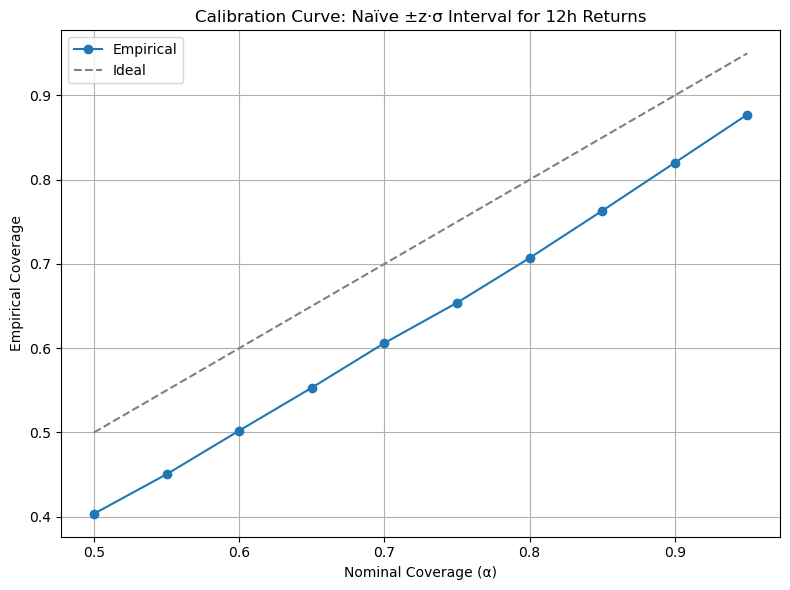

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# 1. Load the final, imputed dataset
df = pd.read_parquet("C:/Users/james/OneDrive/Documents/GitHub/solana-qrf-interval-forecasting/data/06data.parquet")

# 2. Use 12h returns and realized volatility (36h window std) for calibration
df_cal = df[['return_12h', 'realized_vol_12h']].dropna()

# 3. Define nominal coverage levels and compute empirical coverage
alphas = np.linspace(0.50, 0.95, 10)  # 50%, 55%, …, 95%
results = []

for alpha in alphas:
    z = norm.ppf((1 + alpha) / 2)           # two-sided z-score
    lower = -z * df_cal['realized_vol_12h']
    upper = +z * df_cal['realized_vol_12h']
    covered = ((df_cal['return_12h'] >= lower) & (df_cal['return_12h'] <= upper)).mean()
    results.append({'nominal': alpha, 'empirical': covered})

cal_df = pd.DataFrame(results)

# 4. Plot calibration curve
plt.figure(figsize=(8, 6))
plt.plot(cal_df['nominal'], cal_df['empirical'], marker='o', label='Empirical')
plt.plot([0.5,0.95], [0.5,0.95], color='gray', linestyle='--', label='Ideal')
plt.title("Calibration Curve: Naïve ±z·σ Interval for 12h Returns")
plt.xlabel("Nominal Coverage (α)")
plt.ylabel("Empirical Coverage")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Research Notes – Naïve ± z·σ Interval Calibration

**Objective**  
- Establish a simple Gaussian benchmark: how well do ± z·σ bands capture realized 12 h log-returns?

**Method**  
1. For each time point, compute historical sample mean μ and standard deviation σ of 12 h returns.  
2. For nominal coverages α ∈ {50%, 60%, 70%, 80%, 90%, 95%}, form symmetric intervals:  
   > [μ ± z₍α₎·σ]  
3. Measure **empirical coverage**: fraction of actual returns inside each interval.  
4. Plot empirical vs. nominal coverage against the 45° ideal line.

**Key Findings**  
- **Under-coverage at all levels**  
  - 90% band captures only ~82% of returns  
  - 50% band captures only ~40%  
- **Conclusion:** Crypto returns exhibit fat tails and volatility clustering; a Normal assumption is insufficient.

**Why This Matters**  
- **Baseline Failure Mode:** Quantifies exactly how and where Gaussian intervals fall short.  
- **Benchmark for Improvement:** Any advanced interval method (QRF, conformal, etc.) must both  
  1. **Raise empirical coverage** toward the diagonal  
  2. **Sharpen intervals** (narrower width for the same α)

---

### Recommended Additional Diagnostics

1. **Refined Calibration Curves**  
   - Overlay QRF / Kalman / Conformal models’ coverage lines on the same plot.  
   - Compare interval widths at fixed α to assess sharpness gains.

2. **Distributional Checks**  
   - QQ-plots of 12 h returns vs. Normal and Student-t to visualize tail behavior.  
   - Compute rolling skewness and kurtosis to track non-Gaussian dynamics.

3. **Heteroskedasticity & Leverage**  
   - Autocorrelation of squared returns (ARCH effects).  
   - Test for asymmetric volatility (does negative return predict larger σ?).

4. **Regime-Specific Calibration**  
   - Separate “bull” vs. “bear” regimes (using your `regime` flag).  
   - Assess whether naïve intervals deteriorate more in one regime.

By completing these steps, we’ll fully characterize the naïve Gaussian baseline—and precisely measure the value added by our advanced interval-forecasting models—before proceeding to feature engineering and final model development.  


# QRF–Based Interval Calibration